### 고객 주요구매 색상 추출
    
    최초 작성일 : 20/03/12
    작성자 : 김은주
    
    작성내용 : 고객 주요구매 색상 추출
               
               머신러닝 데이터 파악
               -> PRDT_REVIEW 유저별 상품코드 기준 구매한 상품의 색정보 확인
               -> 색 리스트 값 : HSV1, HSV2, ... 데이터로 K_means 군집화를 통해
               -> 소규모 훈련데이터(고객 구매상품 개수)로 인한 Clustering 문제 테스트 > Color Generator 작성
               
               
               Color Generator 작성
               -> 고객 구매상품의 HSV 기준으로 조정값 설정
                  (훈련 성능 비교하여 최종 조정값 결정 예정)
                  (shape : )
               -> 조정값을 반영하여 HSV데이터 Generating
               -> 구매이력이 군집개수보다 적을 경우에도 처리 가능
               
               
               ※ to do list
               1. Clustering 결과값 확인
               2. 대표값이 어떻게 나오는지에 따라 처리를 어떻게 할건지 확인
               3. 최종 HSV만 return? [H, S, V, 라벨or상품코드]

    수정내용 
        20/03/13
               Clustering Algorithm별 성능 비교
                    https://datascienceschool.net/view-notebook/54ee87f1caf84311a0efcbe73fa9e1ea/
                    K-평균 군집화(K-means Clustering)
                    디비스캔 군집화(DBSCAN Clustering)
                    유사도 전파 군집화(Affinity Propagation Clustering)
                    계층적 군집화(Hierarchical Clustering)
                    스펙트럴 군집화(Spectral Clustering)
               
               Color Generator 작성
               -> 

In [9]:
import pandas as pd
import numpy as np
from PIL import Image

import cv2 as cv
# import colour

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname='C:\Windows/Fonts/malgun.ttf').get_name()
plt.rc('font', family=font_name)
mpl.rcParams["axes.unicode_minus"] = False
from matplotlib.colors import hsv_to_rgb

from sklearn.datasets import *
from sklearn.cluster import *
from sklearn.preprocessing import StandardScaler
from sklearn.utils.testing import ignore_warnings
from sklearn.metrics.cluster import adjusted_rand_score

### 색 데이터 제너레이터

In [60]:
h, s, v = 50, 44, 75 # 테스트용
rgb = hsv_to_rgb(np.array([[[h/359, s/100, v/100]]]))

H_ctrl, SV_ctrl = 20, 10 # 조정값

((1, 1), (1, 1, 3))

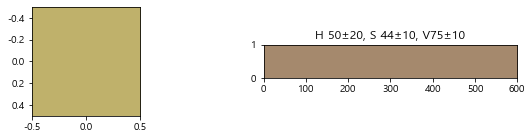

In [63]:
scale = [100j, 100j] # H규모, SV규모

V, H = np.mgrid[(v-SV_ctrl):(v+SV_ctrl):scale[1], (h-H_ctrl):(h+H_ctrl):scale[0]]
S, H = np.mgrid[(s-SV_ctrl):(s+SV_ctrl):scale[1], (h-H_ctrl):(h+H_ctrl):scale[0]]

HSV = np.dstack((H/359, S/100, V/100))
RGB = hsv_to_rgb(HSV)

# 색 출력
plt.figure(figsize=(10, 2))

plt.subplot(121)
plt.imshow(rgb)

plt.subplot(122)
plt.imshow(RGB, origin="lower", extent=[0, 600, 0, 1], aspect=80)
plt.title("H {}±{}, S {}±{}, V{}±{}".format(h, H_ctrl, s, SV_ctrl, v, SV_ctrl))
plt.grid(False)

H.shape, HSV.shape

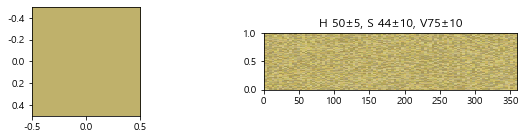

In [82]:
# scale = [100, 100] # H규모, SV규모

# H = np.random.randint(h-H_size, h+H_size, size=(scale[0], scale[1]))
# S = np.random.randint(s-SV_size, s+SV_size, size=(scale[0], scale[1]))
# V = np.random.randint(v-SV_size, v+SV_size, size=(scale[0], scale[1]))

# HSV = np.dstack((H/359, S/100, V/100))
# RGB = hsv_to_rgb(HSV)

# # 색 출력
# plt.figure(figsize=(10, 2))

# plt.subplot(121)
# plt.imshow(rgb)

# plt.subplot(122)
# plt.imshow(RGB, origin="lower", extent=[0, 360, 0, 1], aspect=80)
# plt.title("H {}±{}, S {}±{}, V{}±{}".format(h, H_size, s, SV_size, v, SV_size))
# plt.grid(False)

### 제너레이팅 색 배열 합치기

In [105]:
H_ctrl, SV_ctrl = 20, 10 # 조정값
scale = [10j, 10j] # H규모, SV규모

In [106]:
# 테스트용 1
h, s, v = 50, 44, 75 

V1, H1 = np.mgrid[(v-SV_ctrl):(v+SV_ctrl):scale[1], (h-H_ctrl):(h+H_ctrl):scale[0]]
S1, H1 = np.mgrid[(s-SV_ctrl):(s+SV_ctrl):scale[1], (h-H_ctrl):(h+H_ctrl):scale[0]]
G1 = np.ones_like(V1) * 0

# 테스트용 2
h, s, v = 75, 70, 45

V2, H2 = np.mgrid[(v-SV_ctrl):(v+SV_ctrl):scale[1], (h-H_ctrl):(h+H_ctrl):scale[0]]
S2, H2 = np.mgrid[(s-SV_ctrl):(s+SV_ctrl):scale[1], (h-H_ctrl):(h+H_ctrl):scale[0]]
G2 = np.ones_like(V2) * 1

# 테스트용 3
h, s, v = 116, 88, 35

V3, H3 = np.mgrid[(v-SV_ctrl):(v+SV_ctrl):scale[1], (h-H_ctrl):(h+H_ctrl):scale[0]]
S3, H3 = np.mgrid[(s-SV_ctrl):(s+SV_ctrl):scale[1], (h-H_ctrl):(h+H_ctrl):scale[0]]
G3 = np.ones_like(V3) * 2

# # 테스트용 4
# h, s, v = 142, 88, 35

# V4, H4 = np.mgrid[(v-SV_ctrl):(v+SV_ctrl):scale[1], (h-H_ctrl):(h+H_ctrl):scale[0]]
# S4, H4 = np.mgrid[(s-SV_ctrl):(s+SV_ctrl):scale[1], (h-H_ctrl):(h+H_ctrl):scale[0]]
# G4 = np.ones_like(V4) * 3

# # 테스트용 5
# h, s, v = 142, 88, 35

# V5, H5 = np.mgrid[(v-SV_ctrl):(v+SV_ctrl):scale[1], (h-H_ctrl):(h+H_ctrl):scale[0]]
# S5, H5 = np.mgrid[(s-SV_ctrl):(s+SV_ctrl):scale[1], (h-H_ctrl):(h+H_ctrl):scale[0]]
# G5 = np.ones_like(V5) * 4

# # 테스트용 6
# h, s, v = 142, 88, 35

# V6, H6 = np.mgrid[(v-SV_ctrl):(v+SV_ctrl):scale[1], (h-H_ctrl):(h+H_ctrl):scale[0]]
# S6, H6 = np.mgrid[(s-SV_ctrl):(s+SV_ctrl):scale[1], (h-H_ctrl):(h+H_ctrl):scale[0]]
# G6 = np.ones_like(V6) * 5

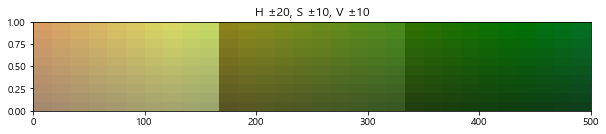

In [107]:
H = np.hstack((H1, H2, H3))
S = np.hstack((S1, S2, S3))
V = np.hstack((V1, V2, V3))
G = np.hstack((G1, G2, G3)) # groundthuth

HSV = np.dstack((H/359, S/100, V/100, G))
RGB = hsv_to_rgb(HSV[:, :, :3])

# 색 출력
plt.figure(figsize=(10, 2))

plt.imshow(RGB, origin="lower", extent=[0, 500, 0, 1], aspect=80)
plt.title("H ±{}, S ±{}, V ±{}".format(H_ctrl, SV_ctrl, SV_ctrl))
plt.grid(False)

### Color Generator
    1. 전달할 데이터
        HSV : 개수변동
        조정할 사이즈 : Clustering 성능 비교 후 확정
        확대할 사이즈 : Clustering 성능 비교 후 확정
    2. HSV별 데이터 확대 후 배열 합치기(반복문 계속 돌리면 되려나)
    3. clustering 할 3차원 배열 리턴
    4. 최종 -> 클래스로 만들기 / PersonalColorPalette 클래스 안에 함수로 추가...? 별도로 클래스...?

In [73]:
def color_generator(hsv_list, ctrl, scale):
    # hsv_list = [[h1, s1, v1], [h2, s2, v3], ...]
    # ctrl = [H조정값, SV조정값]
    # scale = [H확장규모, SV확장규모]
    # 라벨?상품코드? 있어야할지도 모르겠음
    
    
    V, H = np.mgrid[(hsv_list[0][2]-(ctrl[1])):(hsv_list[0][2]+(ctrl[1])):complex(scale[1]),
                        (hsv_list[0][0]-(ctrl[0])):(hsv_list[0][0]+(ctrl[0])):complex(scale[0])]
    S, H = np.mgrid[(hsv_list[0][1]-(ctrl[1])):(hsv_list[0][1]+(ctrl[1])):complex(scale[1]),
                        (hsv_list[0][0]-(ctrl[0])):(hsv_list[0][0]+(ctrl[0])):complex(scale[0])]
    G = np.ones_like(V) * 0
    
    if len(hsv_list) > 1:
        for (h, s, v), i in zip(hsv_list[1:], range(len(hsv_list[1:]))):
            V_n, H_n = np.mgrid[(v-(ctrl[1])):(v+(ctrl[1])):complex(scale[1]), (h-(ctrl[0])):(h+(ctrl[0])):complex(scale[0])]
            S_n, H_n = np.mgrid[(s-(ctrl[1])):(s+(ctrl[1])):complex(scale[1]), (h-(ctrl[0])):(h+(ctrl[0])):complex(scale[0])]
            G_n = np.ones_like(V_n) * i

            H = np.hstack((H, H_n))
            S = np.hstack((S, S_n))
            V = np.hstack((V, V_n))
            G = np.hstack((G, G_n)) # groundthuth
            
    HSV = np.dstack((H, S, V, G))
    
    # 제너레이팅 데이터 시각화
    hsv = np.dstack((H/359, S/100, V/100))
    rgb = hsv_to_rgb(hsv)
    
    plt.figure(figsize=(10, 2))

    plt.imshow(rgb, origin="lower", extent=[0, 500, 0, 1], aspect=80)
    plt.title("H ±{}, S ±{}, V ±{}".format(ctrl[0], ctrl[1],ctrl[1]))
    plt.grid(False)
    
    return HSV

In [74]:
## 색 샘플 데이터 군집화용 데이터조정

def clustering_dataset(HSV):
    x_size = HSV.shape[0]*HSV.shape[1]
    y_size = HSV.shape[2]

    blobs = HSV[:, :, :3].reshape(x_size, y_size-1), HSV[:, :, 3].reshape(x_size)
    anisotropic = HSV[:, :, :3].reshape(x_size, y_size-1), HSV[:, :, 3].reshape(x_size)
    varied = HSV[:, :, :3].reshape(x_size, y_size-1), HSV[:, :, 3].reshape(x_size)
    noisy_circles = HSV[:, :, :3].reshape(x_size, y_size-1), HSV[:, :, 3].reshape(x_size)
    noisy_moons = HSV[:, :, :3].reshape(x_size, y_size-1), HSV[:, :, 3].reshape(x_size)
    no_structure = HSV[:, :, :3].reshape(x_size, y_size-1), None

    datasets = {
        "같은 크기의 원형": blobs, 
        "같은 크기의 타원형": anisotropic, 
        "다른 크기의 원형": varied, 
        "초승달": noisy_moons, 
        "동심원": noisy_circles, 
        "비구조화": no_structure
    }

    print(blobs[0].shape, blobs[1].shape)
    print(anisotropic[0].shape, anisotropic[1].shape)
    print(varied[0].shape, varied[1].shape)
    print(noisy_circles[0].shape, noisy_circles[1].shape)
    print(noisy_moons[0].shape, noisy_moons[1].shape)
    print(no_structure[0].shape)
    
    return datasets

### Clustering_test

(800, 3) (800,)
(800, 3) (800,)
(800, 3) (800,)
(800, 3) (800,)
(800, 3) (800,)
(800, 3)


IndexError: index 20 is out of bounds for axis 0 with size 20

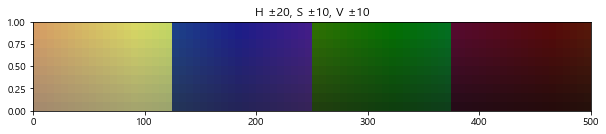

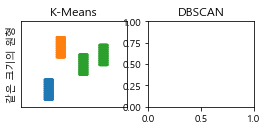

In [78]:
# 색상 데이터 확장 & 클러스터링 성능비교용 데이터셋 생성
## color_generator용 변수
hsv = [[50, 44, 75], [240, 70, 45], [116, 88, 35], [350, 80, 25]] # 테스트용
ctrl, scale = [20, 10], [20, 10] # [H조정, SV조정], [H규모, SV규모]

HSV = color_generator(hsv, ctrl, scale)
performance = clustering_test(clustering_dataset(HSV))
performance

In [77]:
def clustering_test(datasets):
    plt.figure(figsize=(11, 11))
    plot_num = 1
    ARI = [] # 성능평가(조정랜드지수) 담을 변수

    for i, (data_name, (X, y)) in enumerate(datasets.items()):
        if data_name in ["초승달", "동심원"]:
            n_clusters = 3
        else:
            n_clusters = 3

        X = StandardScaler().fit_transform(X)

        two_means = MiniBatchKMeans(n_clusters=n_clusters)
        dbscan = DBSCAN(eps=0.15)
        spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors') #'nearest_neighbors':안됨, 'precomputed', 'rbf':안됨
        ward = AgglomerativeClustering(n_clusters=n_clusters)
        affinity_propagation = AffinityPropagation(damping=0.9) # 배열사이즈 preference=-200
        clustering_algorithms = (
            ('K-Means', two_means),
            ('DBSCAN', dbscan),
            ('Hierarchical Clustering', ward),
            ('Affinity Propagation', affinity_propagation),
            ('Spectral Clustering', spectral),
        )

        ari = []
        for j, (name, algorithm) in enumerate(clustering_algorithms):
            with ignore_warnings(category=UserWarning):
                algorithm.fit(X)
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(X)

            if data_name != "비구조화":
                ari.append(round(adjusted_rand_score(y, y_pred)*100, 2)) # 조정 랜드지수 산출
            plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
            if i == 0:
                plt.title(name)
            if j == 0:
                plt.ylabel(data_name)
            colors = plt.cm.tab10(np.arange(20, dtype=int))
            plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred])
            plt.xlim(-2.5, 2.5)
            plt.ylim(-2.5, 2.5)
            plt.xticks(())
            plt.yticks(())
            plot_num += 1

        if data_name != "비구조화":
            ARI.append(ari)


    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(ARI, index=["같은 크기의 원형", "같은 크기의 타원형", "다른 크기의 원형", "초승달", "동심원"], columns=['K-Means', 'DBSCAN', 'Hierarchical Clustering', 'Affinity Propagation', 'Spectral Clustering'])

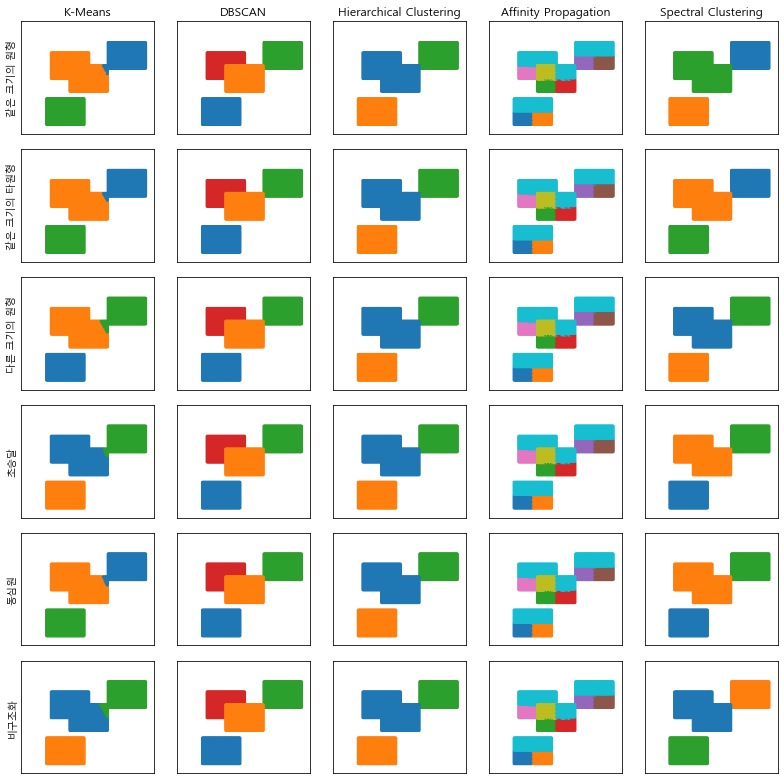

,K-Means,DBSCAN,Hierarchical Clustering,Affinity Propagation,Spectral Clustering
같은 크기의 원형,45.99,71.41,46.64,19.96,46.64
같은 크기의 타원형,46.02,71.41,46.64,19.96,46.64
다른 크기의 원형,45.34,71.41,46.64,19.96,46.64
초승달,46.08,71.41,46.64,19.96,46.64
동심원,45.91,71.41,46.64,19.96,46.64


In [61]:
plt.figure(figsize=(11, 11))
plot_num = 1
ARI = [] # 성능평가(조정랜드지수) 담을 변수

for i, (data_name, (X, y)) in enumerate(datasets.items()):
    if data_name in ["초승달", "동심원"]:
        n_clusters = 3
    else:
        n_clusters = 3

    X = StandardScaler().fit_transform(X)

    two_means = MiniBatchKMeans(n_clusters=n_clusters)
    dbscan = DBSCAN(eps=0.15)
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf') #'nearest_neighbors', 'precomputed', 'rbf'
    ward = AgglomerativeClustering(n_clusters=n_clusters)
    affinity_propagation = AffinityPropagation(damping=0.9) # 배열사이즈 preference=-200
    clustering_algorithms = (
        ('K-Means', two_means),
        ('DBSCAN', dbscan),
        ('Hierarchical Clustering', ward),
        ('Affinity Propagation', affinity_propagation),
        ('Spectral Clustering', spectral),
    )
    
    ari = []
    for j, (name, algorithm) in enumerate(clustering_algorithms):
        with ignore_warnings(category=UserWarning):
            algorithm.fit(X)
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
        
        if data_name != "비구조화":
            ari.append(round(adjusted_rand_score(y, y_pred)*100, 2)) # 조정 랜드지수 산출
        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i == 0:
            plt.title(name)
        if j == 0:
            plt.ylabel(data_name)
        colors = plt.cm.tab10(np.arange(20, dtype=int))
        plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred])
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1
        
    if data_name != "비구조화":
        ARI.append(ari)
    

plt.tight_layout()
plt.show()
pd.DataFrame(ARI, index=["같은 크기의 원형", "같은 크기의 타원형", "다른 크기의 원형", "초승달", "동심원"], columns=['K-Means', 'DBSCAN', 'Hierarchical Clustering', 'Affinity Propagation', 'Spectral Clustering'])